Вы – продуктовый аналитик в автоклассифайде. Вам предстоит проанализировать, как изменилась выручка после проведения акции на покупку услуг продвижения VAS (value added services).

Пользователи видели акцию на различных экранах покупки (купить VAS можно в разных местах продукта). Менеджеры хотят проанализировать каждый экран в отдельности и понять, на каком именно экране есть эффект от акции. Поскольку экранов было несколько, вам нужно проанализировать ABCD тест и сделать поправку на множественную проверку гипотез.

Вам нужно будет использовать данные из таблиц `live_adverts` и `user_transactions`, которые лежат в ClickHouse, и данные о группе пользователя из отдельного файла: `user_groups.csv`

Нужно достать данные по каждому пользователю-листеру на каждый день (пользователи, которые были в таблице `live_adverts` в конкретный день `execution_date`), проверить, были ли у него траты за этот день по таблице `user_transactions`, и достать сумму трат.

На что обратить внимание:

В полученной таблице нужно сагрегировать сумму трат на каждого пользователя при помощи

```SQL
SUM(CASE WHEN sign = -1 AND amount < 0 THEN balance_consumption END) AS money
```


т.к. сейчас каждый пользователь присутствует в таблице несколько раз, что ломает независимость теста. Да и метрика в нашем тесте – не сумма за одну покупку, а сумма за весь период теста.

Период `execution_date`, который нам понадобится:

```SQL
BETWEEN '2022-01-01' AND '2022-02-28'
```

Когда будете делать JOIN таблиц, важно пересечь по каждому объявлению. Для связки используйте условия типа: 

```SQL
CAST(t1.advert_id AS String) = CAST(t2.advert_id AS String)
```

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from clickhouse_driver import Client
from config import user_id, password
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.power import tt_ind_solve_power

client = Client(
    host='clickhouse.lab.karpov.courses',
    port=9000,
    user=user_id,
    password=password,
    database='hardda'
)

def get_data(query):
    """
    Вытягивает данные из clickhouse в виде Dataframe
    
    query - запрос
    """
    result, columns = client.execute(query, with_column_types=True)
    return pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [2]:
user_transactions_query = "SELECT * FROM user_transactions LIMIT 10"

ut_df = get_data(user_transactions_query)
ut_df

,payment_date,id,type,sign,amount,tstamp,advert_id,passport_id,balance_consumption
0,2021-02-02,542155845,unset automatic renewal,1,0,2021-02-02 17:15:28,235441104,123944616,0
1,2021-02-02,542163099,automatic renewal,1,0,2021-02-02 17:30:04,238859124,124677806,0
2,2021-02-02,541926300,unset automatic renewal,1,0,2021-02-02 11:10:38,232311902,124531521,0
3,2021-02-02,542110167,automatic renewal,1,0,2021-02-02 15:54:12,238796149,126114083,0
4,2021-02-02,541809192,unset automatic renewal,1,0,2021-02-02 06:04:28,238294682,134286983,0
5,2021-02-02,542252016,unset automatic renewal,1,0,2021-02-02 21:23:16,238859511,140592127,0
6,2021-02-02,541990623,automatic renewal,1,0,2021-02-02 12:20:38,238842250,127746703,0
7,2021-02-02,542196432,unset automatic renewal,1,0,2021-02-02 18:43:53,238586248,138274317,0
8,2021-02-02,541808805,unset automatic renewal,1,0,2021-02-02 05:55:12,238526566,135752379,0
9,2021-02-02,542173587,unset automatic renewal,1,0,2021-02-02 17:47:38,238636683,133934141,0


In [3]:
live_adverts_query = "SELECT * FROM live_adverts LIMIT 10"

la_df = get_data(live_adverts_query)
la_df

,execution_date,advert_id,created_at,price,region,user_id,platform,auto_brand,auto_model,passport_id,year,userType
0,2022-02-01,130486371,2012-11-06 07:12:00,0,Москва,123578197,unknown,Unknown,Unknown model,123599132,0,0
1,2022-02-01,129236743,2012-11-06 07:31:13,0,Москва,123477706,unknown,Unknown,Unknown model,123493336,0,0
2,2022-02-01,130358537,2012-11-06 07:35:24,0,Москва,123799514,unknown,Unknown,Unknown model,123820472,0,0
3,2022-02-01,129230893,2012-11-06 08:01:17,0,Москва,123730252,unknown,Unknown,Unknown model,123751205,0,0
4,2022-02-01,169982253,2012-11-06 08:24:59,0,Москва,123653651,unknown,Unknown,Unknown model,123674596,0,0
5,2022-02-01,129615858,2012-11-06 08:39:13,0,Москва,123764303,unknown,Unknown,Unknown model,123785259,0,0
6,2022-02-01,128303169,2012-11-06 08:57:54,0,Москва,123548993,unknown,Unknown,Unknown model,123569924,0,0
7,2022-02-01,124841595,2012-11-06 08:59:45,0,Москва,123548993,unknown,Unknown,Unknown model,123569924,0,0
8,2022-02-01,124950166,2012-11-06 09:53:13,0,Москва,123597697,unknown,Unknown,Unknown model,123618634,0,0
9,2022-02-01,125269022,2012-11-06 15:08:04,9600,Москва,123569121,unknown,Unknown,Unknown model,123590055,0,0


### Задание 1 (1/2)
Выгрузите данные по пользователям, суммарную выручку за период теста `2022-01-01` – `2022-02-28`, а также файл с разметкой (файл с указанием к какой группе относился тот или иной пользователь `user_groups.csv`). Найдите среднее значение выручки.

Введите средний ARPU (money) на пользователя по всему датасету в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

Полезно заменить NAN нулями, так ARPU будет считаться корректнее

In [4]:
user_groups_df = pd.read_csv('user_groups.csv')[['passport_id', 'group']]
user_groups_df.head(10)

,passport_id,group
0,123463044,D
1,123463046,A
2,123463061,C
3,123463062,C
4,123463070,D
5,123463074,B
6,123463086,D
7,123463088,D
8,123463092,A
9,123463106,D


In [5]:
start_date = '2022-01-01'
end_date = '2022-02-28'
    
query = f"""
    SELECT la.execution_date,
        la.passport_id,
        SUM(CASE WHEN u.sign = -1 AND u.amount < 0 THEN u.balance_consumption END) AS money
    FROM live_adverts la 
    LEFT JOIN user_transactions u
    ON u.advert_id::String = la.advert_id::String
        AND la.passport_id = u.passport_id
        AND la.execution_date = u.payment_date
    WHERE execution_date BETWEEN '{start_date}' AND '{end_date}'
    GROUP BY la.execution_date,
        la.passport_id
"""

df = get_data(query)
df

,execution_date,passport_id,money
0,2022-02-02,135223447,NaN
1,2022-02-07,124244293,NaN
2,2022-02-14,136193907,NaN
3,2022-02-16,141516927,NaN
4,2022-02-25,140443031,NaN
...,...,...,...
4545629,2022-02-10,133347793,NaN
4545630,2022-02-17,134371771,NaN
4545631,2022-02-11,136530319,NaN
4545632,2022-02-17,140480887,NaN


In [6]:
df.fillna(0, inplace=True)

In [7]:
arpu_df = df.groupby('passport_id', as_index=False).agg(ARPU=('money', 'sum'))

In [8]:
arpu_df.head()

,passport_id,ARPU
0,123463044,0.0
1,123463046,1880.0
2,123463061,0.0
3,123463062,0.0
4,123463070,0.0


In [9]:
round(arpu_df['ARPU'].mean(), 1)

564.4

### Задание 1 (2/2)
Расположите средние ARPU по группам эксперимента в порядке возрастания.

In [10]:
df = arpu_df.merge(user_groups_df, on = ['passport_id'])
df.head()

,passport_id,ARPU,group
0,123463044,0.0,D
1,123463046,1880.0,A
2,123463061,0.0,C
3,123463062,0.0,C
4,123463070,0.0,D


In [11]:
df.groupby('group', as_index=False).agg(avg_ARPU_group=('ARPU', 'mean')).sort_values('avg_ARPU_group')

,group,avg_ARPU_group
1,B,527.843047
2,C,554.053060
3,D,587.104361
0,A,588.716362


### Задание 2
Оцените p-value значения с помощью стат. теста t-test для проверки гипотез между A-B, A-C, A-D, B-C, B-D, C-D.

In [12]:
df.head()

,passport_id,ARPU,group
0,123463044,0.0,D
1,123463046,1880.0,A
2,123463061,0.0,C
3,123463062,0.0,C
4,123463070,0.0,D


In [13]:
for group in ['A-B', 'A-C', 'A-D', 'B-C', 'B-D', 'C-D']:
    _, pval = ttest_ind(df[df['group'] == group[0]]['ARPU'], df[df['group'] == group[-1]]['ARPU'])
    print(f'Для групп {group} p-value равно: {pval}')

Для групп A-B p-value равно: 0.008708637651968252
Для групп A-C p-value равно: 0.14664911871458192
Для групп A-D p-value равно: 0.954497594329015
Для групп B-C p-value равно: 0.10610807884643546
Для групп B-D p-value равно: 0.007302154505735005
Для групп C-D p-value равно: 0.14723060414169875


### Задание 4 (1/4)
Воспользуйтесь методами поправки Шидака, Холма-Бонферрони. Какие скорректированные пороговые alpha (новый уровень стат. значимости) получатся?

Введите новый скорректированный альфа для метода Шидака в поле ниже с точностью до четырех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [14]:
p_values = []

for group in ['A-B', 'A-C', 'A-D', 'B-C', 'B-D', 'C-D']:
    _, pval = ttest_ind(df[df['group'] == group[0]]['ARPU'], 
                       df[df['group'] == group[-1]]['ARPU'])
    p_values.append(pval)
    print(f'Для групп {group} исходное p-value: {pval}')

data_hyp = pd.DataFrame({'hypothesis': ['AB', 'AC', 'AD', 'BC', 'BD',' CD'],
                         'p_values': p_values})

Для групп A-B исходное p-value: 0.008708637651968252
Для групп A-C исходное p-value: 0.14664911871458192
Для групп A-D исходное p-value: 0.954497594329015
Для групп B-C исходное p-value: 0.10610807884643546
Для групп B-D исходное p-value: 0.007302154505735005
Для групп C-D исходное p-value: 0.14723060414169875


In [15]:
new_alpha = 1 - (1 - 0.05) ** (1/len(p_values))
round(new_alpha, 4)

0.0085

### Задание 4 (2/4)
Какой будет новая скорректированная альфа для метода Холма-Бонферрони для пары A-B?

Введите ответ в поле ниже с точностью до четырех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [16]:
sorted_p_vals_rd = np.sort(np.array(p_values)) # Делаем сортировку p-value значения гипотез

n = sorted_p_vals_rd.shape[0] # кол-во гипотез
rank = range(1, n + 1)
alphas_hb = [(0.05 / (n - r + 1)) for r in rank] # считаем скорректированные alpha

reject_null_hyp = 0
rejects = []

for i in range(sorted_p_vals_rd.shape[0]):
    if sorted_p_vals_rd[i] >= alphas_hb[i]:
        for _ in range(len(rejects), 6):
            rejects.append(False)
        break
    else:
        rejects.append(True)

rejects_p_vals_hb = sorted_p_vals_rd[np.where(rejects)[0]] # Достаём p-value гипотез которые были приняты

data_hyp.sort_values(by = ['p_values'], inplace = True) # сортируем для вставки значении поправленных alpha
data_hyp['alpha_holm_bonferroni'] = alphas_hb # поправленные alpha
data_hyp.sort_index(inplace = True) # возвращаем сортировку

data_hyp[data_hyp['hypothesis'] == 'AB']['alpha_holm_bonferroni']

0    0.01
Name: alpha_holm_bonferroni, dtype: float64

### Задание 4 (3/4)
Какой будет новая скорректированная альфа для метода Холма-Бонферрони для пары B-C?

Введите ответ в поле ниже с точностью до четырех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

### Задание 4 (4/4)
Какой будет новая скорректированная альфа для метода Холма-Бонферрони для пары B-D?

Введите ответ в поле ниже с точностью до четырех знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [17]:
data_hyp

,hypothesis,p_values,alpha_holm_bonferroni
0,AB,0.008709,0.010000
1,AC,0.146649,0.016667
2,AD,0.954498,0.050000
3,BC,0.106108,0.012500
4,BD,0.007302,0.008333
5,CD,0.147231,0.025000


### Задание 5 (1/2)
Какие гипотезы смогли преодолеть критический уровень статистической значимости с учетом скорректированных значений по методу Шидака?

In [18]:
print(f'Для групп B-D исходное p-value: 0.007302154505735005 и это значение меньше, чем {new_alpha}')

Для групп B-D исходное p-value: 0.007302154505735005 и это значение меньше, чем 0.008512444610847103


### Задание 5 (2/2)
Какие гипотезы смогли преодолеть критический уровень статистической значимости с учетом скорректированных значений по методу Холма-Бонферрони?

In [19]:
data_hyp['hyp_w_holm_bonferroni'] = False
data_hyp.loc[data_hyp.query("p_values in @rejects_p_vals_hb").index, 'hyp_w_holm_bonferroni'] = True

print('По методу Холма-Бонферрони принимаются:')
data_hyp.query("hyp_w_holm_bonferroni == True")[['hypothesis']]

По методу Холма-Бонферрони принимаются:


,hypothesis
0,AB
4,BD


### Задание 6 (1/2)
Посчитайте через симуляцию размер выборки с коррекцией Холма-Бонферрони (FWER для альфа= 0.05) такую, чтобы мощность нахождения всех эффектов в размере 20 относительных процентов в парах A-B, A-C, A-D была гарантирована на уровне 0.8. Т.е. если из трех реальных эффектов хотя бы одна гипотеза ложно пропущена, то считается, что мы совершили ошибку второго рода. Т.е. нужно вернуть FWER ошибки второго рода beta к 0.2.

Больше условий для проведения симуляции будет дано на следующем степе.

Перед запуском симуляции определите примерный размер выборки, с которого стоит начинать перебор. Для этого округлите нужный размер выборки для стандартного двустороннего t-test с заданными уровнями альфа, бета и MDE.

Округлите стартовый размер выборки до 10 тыс. в ближайшую сторону: round(sample_size, -4)

Введите ответ в поле ниже в формате целого числа

In [20]:
group_A = df[df['group'] == 'A']['ARPU']

print('Len of primary data =', len(group_A))
mean = group_A.mean()
std = group_A.std()
print('Mean = ', mean, 'Std = ', std)
rel_effect = 0.2
effect_size = mean * rel_effect / std
print('Effect size = ', effect_size)
sample_size = round(tt_ind_solve_power(effect_size=effect_size, alpha=0.05, power=0.8, nobs1=None, alternative='two-sided'), -4)
print('T-test without correction sample size =', sample_size)

Len of primary data = 99285
Mean =  588.7163619882158 Std =  6493.19651644945
Effect size =  0.018133329570321776
T-test without correction sample size = 50000.0


/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6832: RuntimeWarning: invalid value encountered in _nct_sf
  return np.clip(_boost._nct_sf(x, df, nc), 0, 1)
/opt/conda/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:6826: RuntimeWarning: invalid value encountered in _nct_cdf
  return np.clip(_boost._nct_cdf(x, df, nc), 0, 1)


### Задание 6 (2/2)
Рассчитайте нужный размер выборки с коррекцией Холма-Бонферрони через симуляцию (описание на предыдущем степе).

Перед первой инициализацией используйте `np.random.seed(1)`

Начните перебор с того размера выборки, который Вы определили на предыдущем степе.

Обратите внимание, что у нас, в отличии от кода на лекции, уже три гипотезы и функция `np.logical_and` не сможет "переварить" три булевых значения. Необходимо доработать код так, чтобы он мог проверить три гипотезы.

Используйте как базу для симуляции группу А.

Количество симуляций на 1 размер выборки - 200.

Шаг приращения выборки - 1000.

Введите ответ в поле ниже в виде целого числа

In [21]:
def find_multi_tt_sample_size(
    hist_data, 
    n_sim, 
    sample_size_start, 
    rel_effect, 
    sample_size_step, 
    power_set, 
    plot=True, 
    alpha=0.05, 
    method='bonferroni'
):
    '''
    hist_data - метрика по историческим данным, которую мы используем в тесте
    n_sim - кол-во итерраций симуляции для каждого размера выборки
    sample_size_start - с какого значения выборки начинаем перебор
    rel_effect - какой относительный эффект, MDE хотим проверить
    sample_size_step - шаг приращения размера выборки
    power_set - какой мощности хотим достичь
    plot - Отрисовываем ли график
    alpha - Уровень стат.значимости
    method - метод коррекции множественных сравнений
        - `bonferroni` : one-step correction
        - `sidak` : one-step correction
        - `holm-sidak` : step down method using Sidak adjustments
        - `holm` : step-down method using Bonferroni adjustments
        - `simes-hochberg` : step-up method  (independent)
        - `hommel` : closed method based on Simes tests (non-negative)
        - `fdr_bh` : Benjamini/Hochberg  (non-negative)
        - `fdr_by` : Benjamini/Yekutieli (negative)
        - `fdr_tsbh` : two stage fdr correction (non-negative)
        - `fdr_tsbky` : two stage fdr correction (non-negative)
    '''
    
    sample_size_list = []
    power_value_list = []
    power_value_corrected_list = []
    
    while True:
        p_value_list = []
        for i in range(n_sim):
            group_a = np.random.choice(hist_data, size=sample_size_start)
            group_b = np.random.choice(hist_data*(1+rel_effect), size=sample_size_start)
            group_c = np.random.choice(hist_data*(1+rel_effect), size=sample_size_start)
            group_d = np.random.choice(hist_data*(1+rel_effect), size=sample_size_start)
            ab_t_stat, ab_p_value = ttest_ind(group_a, group_b)
            ac_t_stat, ac_p_value = ttest_ind(group_a, group_c)
            ad_t_stat, ad_p_value = ttest_ind(group_a, group_d)
            p_value_list.append((ab_p_value, ac_p_value, ad_p_value))
            
        tp = np.logical_and.reduce([np.array(p_value_list)[:, 0] < alpha, np.array(p_value_list)[:, 1] < alpha, np.array(p_value_list)[:, 2] < alpha])
        # используем logical_and.reduce т.к. сравниваем здесь три булевых значения. Стандартный logical_and так сравнить не может
        
        #скорректируем p-value через метод
        hypothesys = []
        for i in range(len(p_value_list)):
            hypothesys.append(multipletests(p_value_list[i], alpha = alpha, method = method)[0])
        tp_corrected =  np.logical_and.reduce([np.array(hypothesys)[:,0], np.array(hypothesys)[:,1], np.array(hypothesys)[:,2]])
        
        power_value = tp.mean()
        power_value_corrected = tp_corrected.mean()
        power_value_list.append(power_value)
        power_value_corrected_list.append(power_value_corrected)
        sample_size_list.append(sample_size_start)
        #print(i, sample_size_start, power_value)
        if power_value_corrected > power_set + 0.05:
            break
        else:
            sample_size_start += sample_size_step
   
    # рассчитаем итоговые значения размеров выборки
    non_corrected_power = power_value_list[np.argmax(np.array(power_value_list) >= power_set)]
    corrected_power = power_value_corrected_list[np.argmax(np.array(power_value_corrected_list) >= power_set)]
    non_corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_list) >= power_set)]
    corrected_sample_size = sample_size_list[np.argmax(np.array(power_value_corrected_list) >= power_set)]
    
    #отрисовываем график
    if plot: # отрисовываем график набора мощности
        plt.figure(figsize = (16, 8))
        sns.lineplot(x=sample_size_list, y=power_value_list, label='Non corrected power')
        sns.lineplot(x=sample_size_list, y=power_value_corrected_list, label = 'Corrected power')
        plt.axhline(y=0.8, linestyle='--', color='red')
        plt.axvline(x=non_corrected_sample_size, linestyle='--', color='red')
        plt.axvline(x=corrected_sample_size, linestyle='--', color='blue')

        plt.text(x = round(non_corrected_sample_size * 0.97),
                 y = np.quantile(power_value_list, 0.3),
                 s = 'Размер выборки без коррекции ~ {}'.format(non_corrected_sample_size),
                rotation = 'vertical',
                color = 'red')
        plt.text(x = round(corrected_sample_size * 0.97),
                 y = np.quantile(power_value_list, 0.3),
                 s = 'Размер выборки c коррекцией ~ {}'.format(corrected_sample_size),
                rotation = 'vertical',
                color = 'blue')
        
    return_object = {
        'non_corrected sample_size': non_corrected_sample_size,
        'corrected sample size': corrected_sample_size,
        'non corrected power':non_corrected_power,
        'corrected power':corrected_power
    }
    
    return(return_object)

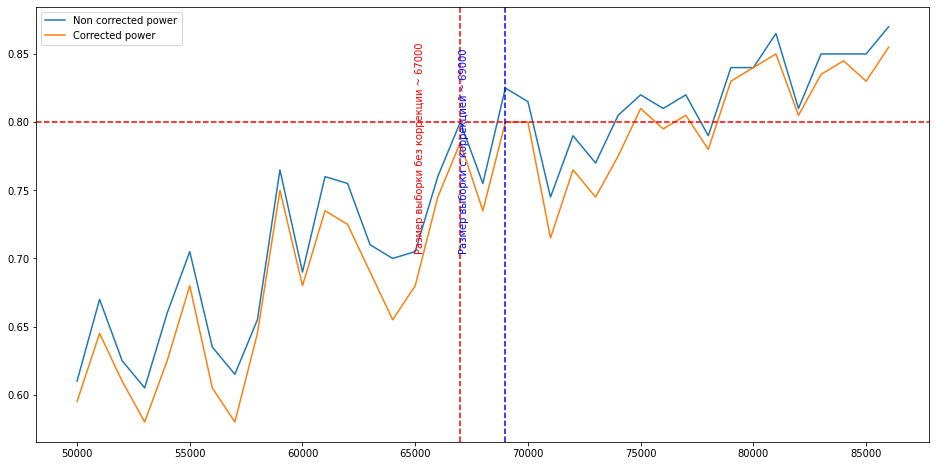

In [22]:
np.random.seed(1)
object = find_multi_tt_sample_size(group_A, 200, int(round(sample_size, -4)), 0.2, 1000, 0.8, plot=True, method='holm')

In [23]:
print('6.2. Скорректированный размер выборки =', object['corrected sample size'])

6.2. Скорректированный размер выборки = 69000
